**Задание**
Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации
2. Рассмотреть 2-а варианта сеточек 
2.1 Инициализировать tf.keras.layers.Embedding предобученными векторами взять к примеру с https://rusvectores.org/ru/
2.2 Инициализировать слой tf.keras.layers.Embedding по умолчанию (ну то есть вам ничего не делать с весами)
 				
Сравнить две архитектуры с предобученными весами и когда tf.keras.layers.Embedding обучается сразу со всей сеточкой, что получилось лучше

In [1]:
import pandas as pd
data = pd.read_excel("отзывы за лето.xls")
data.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [4]:
data.Rating.value_counts()

5    14586
1     2276
4     2138
3      911
2      748
Name: Rating, dtype: int64

Наблюдаем дисбаланс классов поэтому будем использовать F1score и classification report для оценки моделей

In [5]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [7]:
exclude = set(punctuation)
sw = set(get_stop_words("ru"))
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in exclude]
    return " ".join(txt)

data['text'] = data['Content'].apply(preprocess_text)

In [8]:
data.head()

,Rating,Content,Date,text
0,5,It just works!,2017-08-14,it just works
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,в целое удобноной приложениеиз минус хотеть сл...
2,5,Отлично все,2017-08-14,отлично всё
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,стать зависать на 1 работа антивирус далёкий н...
4,5,"Очень удобно, работает быстро.",2017-08-14,очень удобно работать быстро


In [15]:
# Разделение выборки на тренировочную, тестовую и валидационную

from sklearn.model_selection import train_test_split

train_df, test_val_df,  = train_test_split(data, test_size=0.2,
                                                    random_state=42, stratify=data['Rating'])

test_df, val_df = train_test_split(test_val_df,
                                    test_size=0.5, stratify=test_val_df['Rating'], random_state=42)

In [17]:
train_df.shape, test_df.shape, val_df.shape

((16527, 4), (2066, 4), (2066, 4))

In [21]:
# Создание корпуса

train_corpus = " ".join(train_df['text'])
train_corpus = train_corpus.lower()

In [23]:
# Токенизация корпуса

import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)

<BarContainer object of 295 artists>

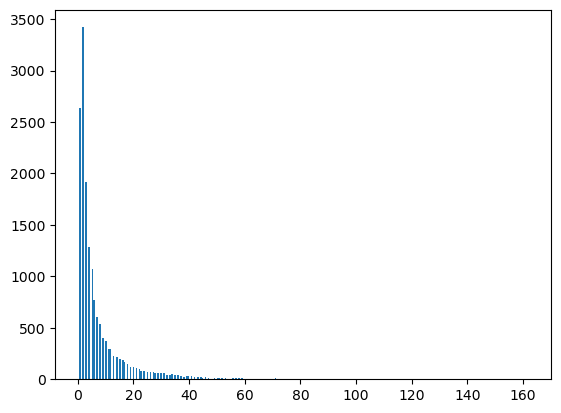

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.text.apply(lambda text: len(text.split())), bins='auto')
hist

In [29]:
# Настраиваемые параметры сети

max_words = 1000
max_len = 80
num_classes = 6

In [57]:
# Настраиваемые параметры обучения

epochs = 28
batch_size = 512
print_batch_n = 100

In [30]:
# Сортировка и отбор самых частотных токенов

from nltk.probability import FreqDist

tokens_filtered = [word for word in tokens if word.isalnum()]

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [31]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [32]:
import numpy as np

def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [33]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in train_df['text']], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in test_df['text']], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in val_df['text']], dtype=np.int32)

In [39]:
# Импорт библиотек для работы нейронной сети

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
# from keras.objectives import categorical_crossentropy
from keras.callbacks import EarlyStopping  
from keras.utils import np_utils

from keras.callbacks import TensorBoard 
from keras.metrics import categorical_crossentropy
from keras.callbacks import EarlyStopping

In [37]:
# !pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 1.9 MB/s eta 0:00:0000:0100:01


In [38]:
import tensorflow_addons as tfa

/Users/aleksandrkrylov/anaconda3/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [36]:
y_train = keras.utils.np_utils.to_categorical(train_df['Rating'], num_classes)
y_test = keras.utils.np_utils.to_categorical(test_df['Rating'], num_classes)
y_val = keras.utils.np_utils.to_categorical(val_df['Rating'], num_classes)

In [58]:
# Сеть

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [59]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', tfa.metrics.F1Score(num_classes=num_classes, average='macro')])

In [60]:
tensorboard = TensorBoard(log_dir='./logs', write_graph=True, write_images=True)


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (x_val, y_val),
                    callbacks=[tensorboard])

Epoch 1/28
33/33 [==============================] - 9s 224ms/step - loss: 1.2175 - accuracy: 0.6855 - f1_score: 0.1478 - val_loss: 0.9130 - val_accuracy: 0.7057 - val_f1_score: 0.1379
Epoch 2/28
33/33 [==============================] - 8s 229ms/step - loss: 0.8362 - accuracy: 0.7286 - f1_score: 0.2072 - val_loss: 0.6860 - val_accuracy: 0.7628 - val_f1_score: 0.2397
Epoch 3/28
33/33 [==============================] - 7s 198ms/step - loss: 0.6931 - accuracy: 0.7685 - f1_score: 0.2654 - val_loss: 0.6525 - val_accuracy: 0.7711 - val_f1_score: 0.2476
Epoch 4/28
33/33 [==============================] - 6s 185ms/step - loss: 0.6499 - accuracy: 0.7795 - f1_score: 0.2762 - val_loss: 0.6423 - val_accuracy: 0.7740 - val_f1_score: 0.2603
Epoch 5/28
33/33 [==============================] - 6s 195ms/step - loss: 0.6225 - accuracy: 0.7883 - f1_score: 0.2994 - val_loss: 0.6346 - val_accuracy: 0.7749 - val_f1_score: 0.2751
Epoch 6/28
33/33 [==============================] - 6s 178ms/step - loss: 0.5994

In [64]:
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

5/5 [==============================] - 0s 37ms/step - loss: 1.0252 - accuracy: 0.7498 - f1_score: 0.3156


In [65]:
results = model.predict(x_test, batch_size=batch_size, verbose=1)

5/5 [==============================] - 0s 43ms/step


In [70]:
results_label = [np.round(x) for x in results]

In [71]:
from sklearn.metrics import classification_report

print(classification_report(y_test, results_label))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.54      0.58      0.56       227
           2       0.18      0.05      0.08        75
           3       0.19      0.05      0.08        91
           4       0.28      0.16      0.20       214
           5       0.87      0.93      0.90      1459

   micro avg       0.78      0.74      0.76      2066
   macro avg       0.34      0.30      0.30      2066
weighted avg       0.72      0.74      0.72      2066
 samples avg       0.74      0.74      0.74      2066



/Users/aleksandrkrylov/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aleksandrkrylov/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aleksandrkrylov/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Embedding слой с предобученными векторами

In [72]:
!wget http://vectors.nlpl.eu/repository/20/220.zip

--2023-05-28 10:07:12--  http://vectors.nlpl.eu/repository/20/220.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638171816 (609M) [application/zip]
Saving to: '220.zip'

220.zip             100%[===================>] 608.61M   611KB/s    in 5m 46s  

2023-05-28 10:13:00 (1.76 MB/s) - '220.zip' saved [638171816/638171816]



In [73]:
!unzip 220.zip

Archive:  220.zip
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               
  inflating: README                  


In [74]:
import gensim

In [75]:
#загрузим векторы модели ruwikiruscorpora_upos_cbow_300_10_2021 (https://rusvectores.org/ru/models/)
word_model = gensim.models.KeyedVectors.load_word2vec_format('model.bin', binary=True)  

In [76]:
len(word_model)

249333

In [81]:
#обрежем по размеру эмбеддингов предыдущей задачи
word_model_matrix = [word_model[i][:128] for i in range(1000)]

In [82]:
initializer = keras.initializers.Constant(word_model_matrix)

In [83]:
model_w = Sequential()
model_w.add(Embedding(input_dim=max_words, output_dim=128, embeddings_initializer =initializer, input_length=max_len))
model_w.add(Conv1D(128, 3))
model_w.add(Activation("relu"))
model_w.add(GlobalMaxPool1D())
model_w.add(Dense(64))
model_w.add(Activation("relu"))
model_w.add(Dropout(0.5))
model_w.add(Dense(num_classes))
model_w.add(Activation('softmax'))

In [84]:
model_w.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', tfa.metrics.F1Score(num_classes=num_classes, average='macro')])

In [85]:
tensorboard = TensorBoard(log_dir='./logs', write_graph=True, write_images=True)


history_1 = model_w.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (x_val, y_val),
                    callbacks=[tensorboard])

Epoch 1/28
33/33 [==============================] - 7s 182ms/step - loss: 1.7142 - accuracy: 0.6391 - f1_score: 0.2163 - val_loss: 0.8333 - val_accuracy: 0.7154 - val_f1_score: 0.1850
Epoch 2/28
33/33 [==============================] - 6s 172ms/step - loss: 0.8909 - accuracy: 0.7125 - f1_score: 0.2276 - val_loss: 0.7580 - val_accuracy: 0.7367 - val_f1_score: 0.2224
Epoch 3/28
33/33 [==============================] - 5s 155ms/step - loss: 0.8241 - accuracy: 0.7299 - f1_score: 0.2350 - val_loss: 0.7323 - val_accuracy: 0.7372 - val_f1_score: 0.2245
Epoch 4/28
33/33 [==============================] - 5s 156ms/step - loss: 0.7778 - accuracy: 0.7407 - f1_score: 0.2373 - val_loss: 0.7307 - val_accuracy: 0.7425 - val_f1_score: 0.2248
Epoch 5/28
33/33 [==============================] - 5s 148ms/step - loss: 0.7504 - accuracy: 0.7459 - f1_score: 0.2408 - val_loss: 0.7341 - val_accuracy: 0.7473 - val_f1_score: 0.2262
Epoch 6/28
33/33 [==============================] - 5s 152ms/step - loss: 0.7293

In [86]:
score_w = model_w.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

5/5 [==============================] - 0s 33ms/step - loss: 0.7256 - accuracy: 0.7594 - f1_score: 0.3098


In [87]:
results_w = model_w.predict(x_test, batch_size=batch_size, verbose=1)

5/5 [==============================] - 0s 29ms/step


In [90]:
results_label_w = [np.round(x) for x in results_w]

In [91]:
print(classification_report(y_test, results_label_w))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.56      0.38      0.45       227
           2       0.00      0.00      0.00        75
           3       1.00      0.01      0.02        91
           4       0.39      0.06      0.10       214
           5       0.87      0.94      0.91      1459

   micro avg       0.83      0.71      0.77      2066
   macro avg       0.47      0.23      0.25      2066
weighted avg       0.76      0.71      0.70      2066
 samples avg       0.71      0.71      0.71      2066



/Users/aleksandrkrylov/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aleksandrkrylov/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aleksandrkrylov/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


При использовании предобученного эмбединга качесттво стало немного хуже